# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


**Входные данные** Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.  

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Цель исследования** Нужно спрогнозировать, планирует ли пользователь уйти в ближайшее время или нет. 

**Результаты исследования** Построить модель с предельно большим значением *roc-auc*.

**Ход исследования**
Источник данных: /datasets/final_provider/.


In [2468]:
import datetime
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [2469]:
# отключить некритические предупреждения в коде
warnings.filterwarnings("ignore")

In [2470]:
# убрать экспонентациальные формы при выводе данных
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2471]:
# сбросим ограничение на количество выводимых столбцов, что бы просмотреть все столбцы
pd.set_option('display.max_columns', None)

## Обзор данных

Сохраним все предоставленные данные в несколько DataFrame посмотрим первые 5 строк полученных таблиц 

In [2472]:
contract = pd.read_csv('***')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [2473]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет, даты начала и конца действия договора необходимо изменить тип данных, суммарный платеж необходимо изменить тип данных.

In [2474]:
internet = pd.read_csv('***')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [2475]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет, тип данных соответствует ожидаемому.

In [2476]:
personal = pd.read_csv('***')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [2477]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [2478]:
phone = pd.read_csv('***')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [2479]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод**  
Пропусков в таблицах нет.  
Предварительно можно утверждать, что, данных достаточно для  анализа поведения клиентов, что бы построить модель прогнозирования оттока клиентов.

*Необходимо*:  

    - изменить тип данных по столбцам, где это необходимо  
    - проанализировать данные на наличие аномалий и ошибок    
    - сгруппировать предоставленные таблицы  по пользователю и объединить в единую таблицу , выделить таргет.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Подготовка данных

### Изменение типа данных и добавление целевой переменной

In [2480]:
# посмотрим столбец с датой окончания договоров
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Определим целевую переменную следующим образом: по договорам , которые прекратили действие (т.е. дата окончания не 'No') метка , что договор расторгнут (1), все остальные договора метка , что договор действующий (0-договор не расторгнут). Добавим значение таргета в таблицу.

In [2481]:
contract['target'] = [1 if i != 'No' else 0 for i in contract['EndDate']]

In [2482]:
# посмотрим столбец с датой окончания договоров
contract['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

In [2483]:
# заполним 'no' датой на которую предоставлены данные 2020-02-01
contract.loc[(contract['EndDate'] == 'No'),'EndDate'] = '2020-02-01 00:00:00'

In [2484]:
# изменим тип данных начала и конца действия договора для анализа данных столбцов
contract['EndDate'] = pd.to_datetime(contract['EndDate'],format= "%Y/%m/%d")
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'],format= "%Y/%m/%d")

In [2485]:
contract['TotalCharges'].value_counts().sort_index()

          11
100.2      1
100.25     1
100.35     1
100.4      1
          ..
997.75     1
998.1      1
999.45     1
999.8      1
999.9      1
Name: TotalCharges, Length: 6531, dtype: int64

Посмотрим , что за 11 клиентов, у которых суммарнуй платеж отсутствует. 

In [2486]:
contract.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0


Это клиенты, подписавышие договор 2020-02-01, т.е. на момент выгрузки данных у них дествительно отсутствовал платеж, это новички. заполним пропущенные значения нулями.

In [2487]:
# изменим тип данных по столбцу TotalCharges
contract.loc[(contract['TotalCharges'] == ' '),'TotalCharges'] = '0.00'
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

### Проанализировать данные на наличие аномалий и ошибок

####  Таблица contract

In [2488]:
#посмотрим основные статистики по столбцам
contract.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
customerID,7043,7043,6350-XFYGW,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01 00:00:00,366,2013-10-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,2020-02-01 00:00:00,5174,2019-10-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,"7,043.00",NaN,NaN,NaN,NaT,NaT,64.76,30.09,18.25,35.50,70.35,89.85,118.75
TotalCharges,"7,043.00",NaN,NaN,NaN,NaT,NaT,"2,279.73","2,266.79",0.00,398.55,"1,394.55","3,786.60","8,684.80"
target,"7,043.00",NaN,NaN,NaN,NaT,NaT,0.27,0.44,0.00,0.00,0.00,1.00,1.00


In [2489]:
# посмотрим столбец с датой окончания договоров
contract['EndDate'].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [2490]:
# посмотрим столбец с датой начала договоров
contract['BeginDate'].value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

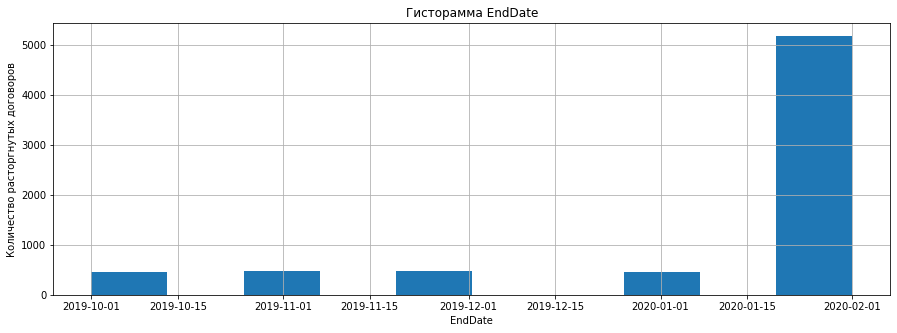

In [2491]:
plt.figure(figsize=(15,5))
contract['EndDate'].hist()
plt.ylabel('Количество расторгнутых договоров')
plt.xlabel('EndDate')
plt.title('Гисторамма EndDate')
plt.show()

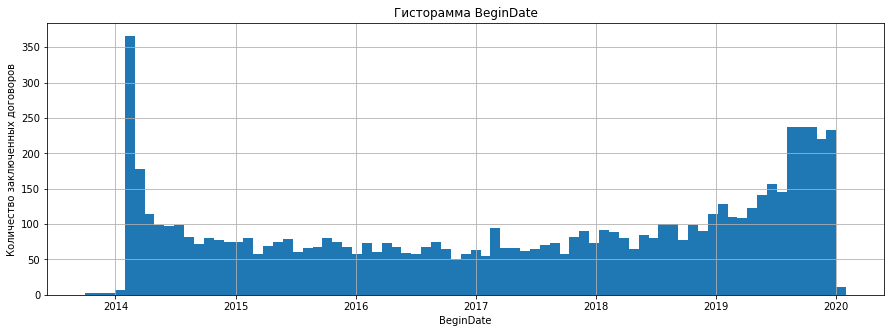

In [2492]:
plt.figure(figsize=(15,5))
contract['BeginDate'].hist(bins=77)
plt.ylabel('Количество заключенных договоров')
plt.xlabel('BeginDate')
plt.title('Гисторамма BeginDate')
plt.show()

Рассчитаем разницу между датой начала договора и датой окончания(только по договорам закрытым до отчетной даты) в месяцах и построим гистограмму распределения и боксплот.

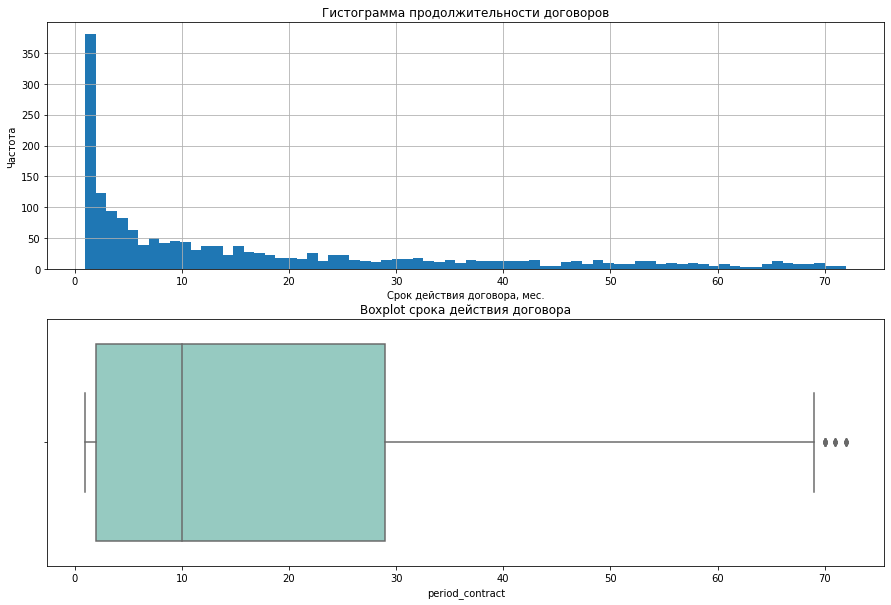

In [2493]:
df=contract.query('EndDate!="2020-02-01"')
df['period_contract'] = round((df['EndDate']-df['BeginDate'])/np.timedelta64(1,'M'),0)
plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
df['period_contract'].hist(bins=72)
plt.title(f'Гистограмма продолжительности договоров')
plt.xlabel(f'Срок действия договора, мес.')
plt.ylabel('Частота')

plt.subplot(2, 1, 2)
sns.boxplot(df['period_contract'], orient="h", palette="Set3")
plt.title(f'Boxplot срока действия договора')      
plt.show()


In [2494]:
df['period_contract'].describe()

count   1,869.00
mean       17.98
std        19.53
min         1.00
25%         2.00
50%        10.00
75%        29.00
max        72.00
Name: period_contract, dtype: float64

Распределение продолжительности договора экспоненциальное, что логично, договоров с коротким сроком больше, чем договоров с длинным сроком.

Построим гистограммы по категориальным столбцам в разрезе таргета.

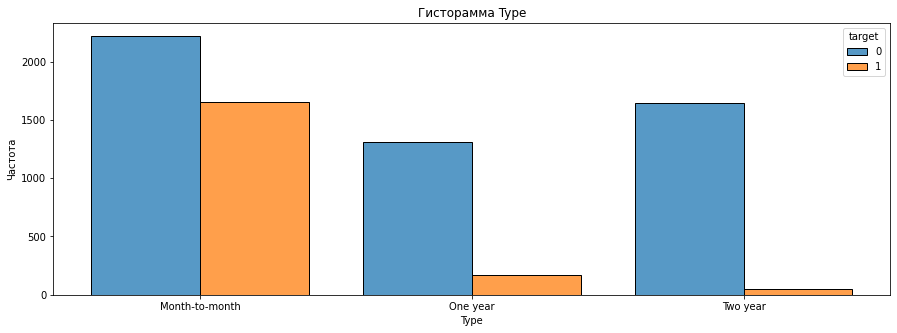

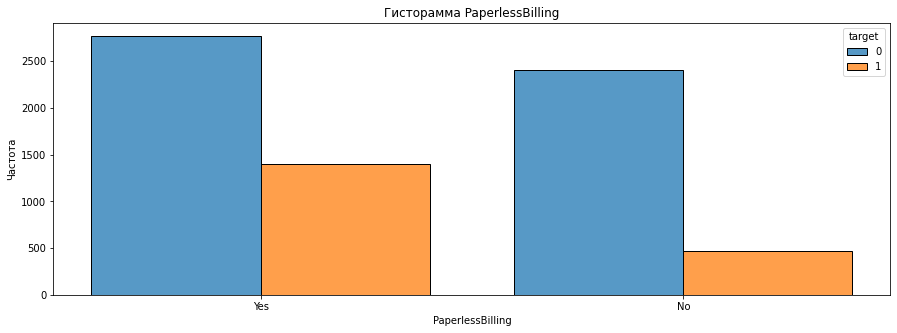

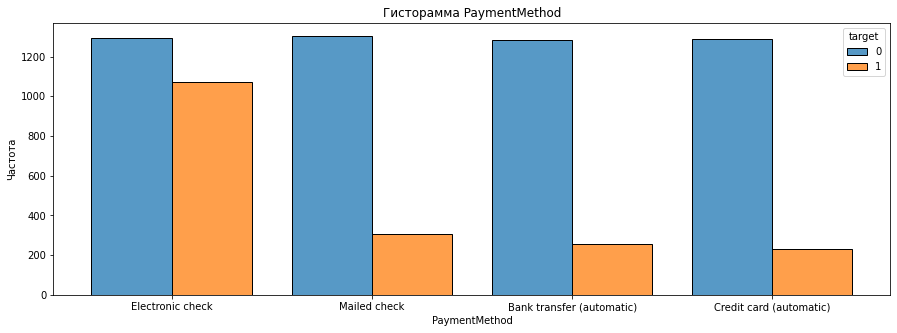

In [2495]:
for i in ['Type','PaperlessBilling','PaymentMethod']:
    plt.figure(figsize=(15,5))
    sns.histplot(data=contract,x=i,hue='target', multiple="dodge", shrink=.8)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Согласно графикам при Типе оплаты годом или двухлетнем вероятность ухода значительно ниже, чем при ежемесячном платеже, так же реже уходят клиенты, у которых наличный расчет оплаты. 

Проверим одну из гипотез: существует зависимость между таргетом и типом оплаты.  
Цель теста - определить, связаны ли две переменные (тип оплаты и таргет) друг с другом.

Нулевая гипотеза:
Нет никакой связи между переменными.  
Альтернативная гипотеза:
между ними существует значительная связь .



In [2496]:
count_table = pd.crosstab(contract['target'],contract['Type']) 
(count_table) 
data = count_table
stat, p, dof, expected = chi2_contingency(data)
# interpret p-value
alpha = 0.05
print ( "p value is " + str (p))
if p <= alpha:
    print ( 'Связь существует (отклонить H0)' )
else :
    print ( 'Переменные независимы (H0 отклонить нельзя)' )

p value is 5.863038300673391e-258
Связь существует (отклонить H0)


Таким образом связь между типом оплаты и таргетом существет.

Закодируем данные столбцов 'Type','PaperlessBilling','PaymentMethod' и добавим в исходную таблицу contract

In [2497]:
contract = contract.join(pd.get_dummies(contract[['Type','PaperlessBilling','PaymentMethod']], drop_first=True))
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,0,1,0,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,"1,889.50",0,1,0,0,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,0,0,1,0,0,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,"1,840.75",0,1,0,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,0,0,1,0,1,0


Добавим в датафрейм новый столбец период действия договора, для его расчета  по незакрытым договорам будем использовать в качестве даты окончания договора дату, на которую предоставлены данные (01.02.2020)

In [2498]:
contract['period']=(contract['EndDate']-contract['BeginDate'])/np.timedelta64(1,'D')

Добавим в датафрейм новый столбец период проплаченный по договору, для его расчета суммарную оплату на дату формирования выгрузки разделим на ежемесячный платеж.

In [2499]:
contract['period_payment']=(contract['TotalCharges']/contract['MonthlyCharges'])

In [2500]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'target',
       'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'period', 'period_payment'],
      dtype='object')

Для финальной таблицы  будем использовать уже закодированные столбцы по категориальным переменным:  
'Type_One year',  
'Type_Two year',  
'PaperlessBilling_Yes',  
'PaymentMethod_Credit card (automatic)',  
'PaymentMethod_Electronic check',  
'PaymentMethod_Mailed check'  

и столбцы с количественными данными:  
'MonthlyCharges',  
'TotalCharges',  
'period',   
'period_payment'  

'BeginDate' и 'EndDate' в дальнейшем  не используем, на базе данных столбцов был сформирован таргет и новый показатель период договора.

Создадим таблицу, которую будем потом использовать при объедиении данных

In [2501]:
contract_ = contract[['customerID',                      
                      'target',
                      'Type_One year',
                      'Type_Two year',
                      'PaperlessBilling_Yes',
                      'PaymentMethod_Credit card (automatic)',
                      'PaymentMethod_Electronic check',
                      'PaymentMethod_Mailed check',
                      'MonthlyCharges',
                      'TotalCharges',
                      'period',
                      'period_payment',
                     ]]

####  Таблица internet

In [2502]:
internet.describe(include='all').T

,count,unique,top,freq
customerID,5517,5517,1794-HBQTJ,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


In [2503]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Проверим, что customerID не дублируются

In [2504]:
internet['customerID'].value_counts().sort_values()

1794-HBQTJ    1
2718-GAXQD    1
1095-WGNGG    1
4789-KWMXN    1
9904-EHEVJ    1
             ..
2391-SOORI    1
8614-VGMMV    1
4900-MSOMT    1
4860-IJUDE    1
2014-MKGMH    1
Name: customerID, Length: 5517, dtype: int64

Проверим,что столбцы StreamingTV и StreamingMovies отличаются

In [2505]:
(internet['StreamingTV']==internet['StreamingMovies']).value_counts()

True     3958
False    1559
dtype: int64

Построим гистограммы по категориальным столбцам в разрезе таргета.

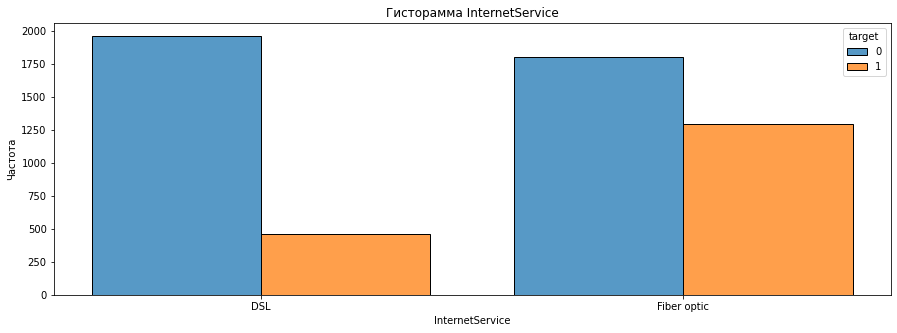

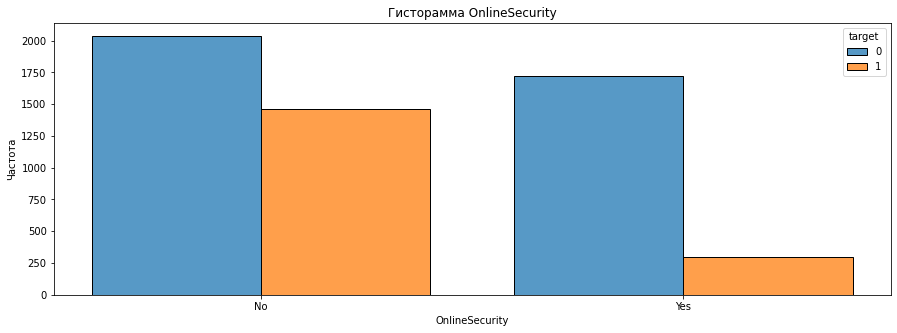

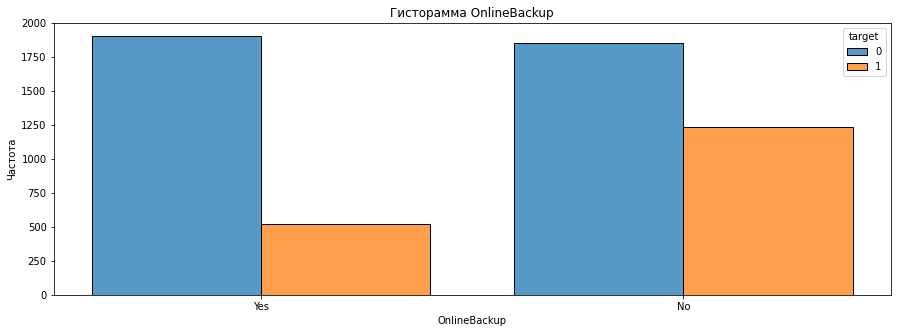

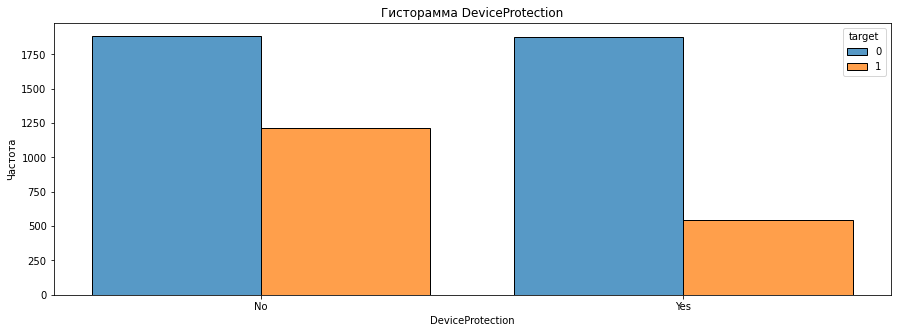

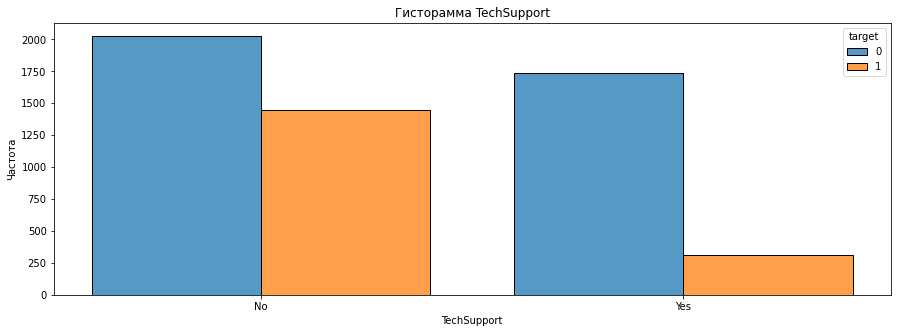

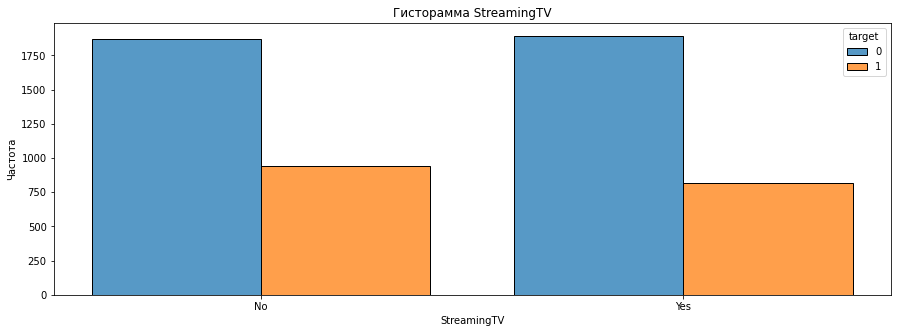

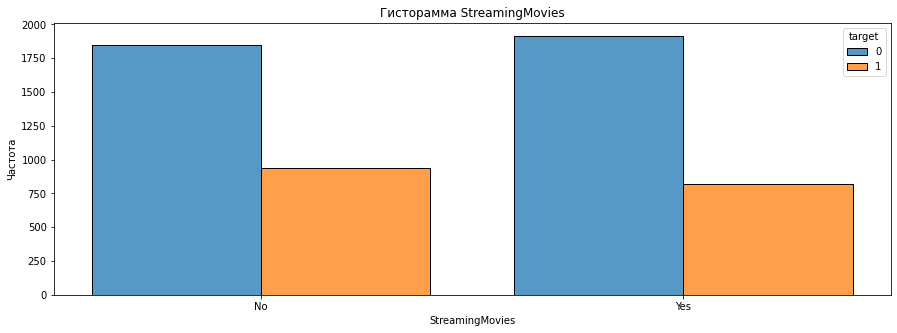

In [2506]:
for i in ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    plt.figure(figsize=(15,5))
    sns.histplot(data=contract.merge(internet,how='outer'),x=i,hue='target', multiple="dodge", shrink=.8)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Наблюдается зависимость таргета от данных признаков, наименьшая зависимость от StreamingMovies и StreamingTV 

Закодируем все категориальные столбцы

In [2507]:
internet = internet.join(pd.get_dummies(internet[['InternetService',
                                                  'OnlineSecurity',
                                                  'OnlineBackup',
                                                  'DeviceProtection',
                                                  'TechSupport',
                                                  'StreamingTV',
                                                  'StreamingMovies']],
                                        drop_first=True))
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,0,0,1,0,0,0,0
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,0,1,0,1,0,0,0
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,0,1,1,0,0,0,0
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,0,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,1,0,0,0,0,0,0


In [2508]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes'],
      dtype='object')

Создадим таблицу, которую будем потом использовать при объедиении данных

In [2509]:
internet_=internet[['customerID',
                    'InternetService_Fiber optic',
                    'OnlineSecurity_Yes',
                    'OnlineBackup_Yes',
                    'DeviceProtection_Yes',
                    'TechSupport_Yes',
                    'StreamingTV_Yes',
                    'StreamingMovies_Yes']]

####  Таблица personal

In [2510]:
personal.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,6350-XFYGW,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,"7,043.00",NaN,NaN,NaN,0.16,0.37,0.00,0.00,0.00,0.00,1.00
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропусков нет.

Построим гистограммы по категориальным столбцам в разрезе таргета.

In [2511]:
personal['SeniorCitizen']=personal['SeniorCitizen'].astype('object')

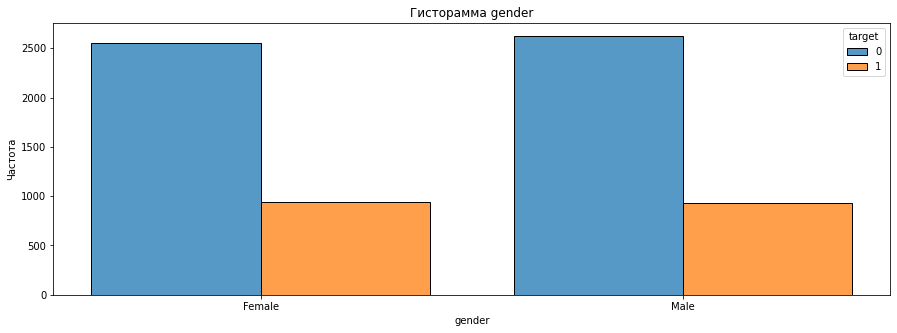

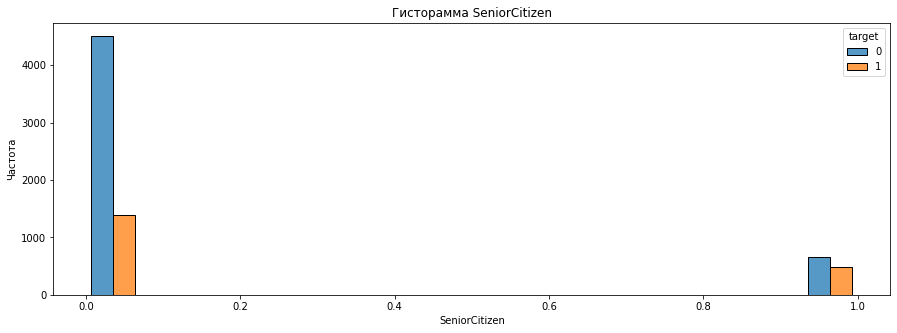

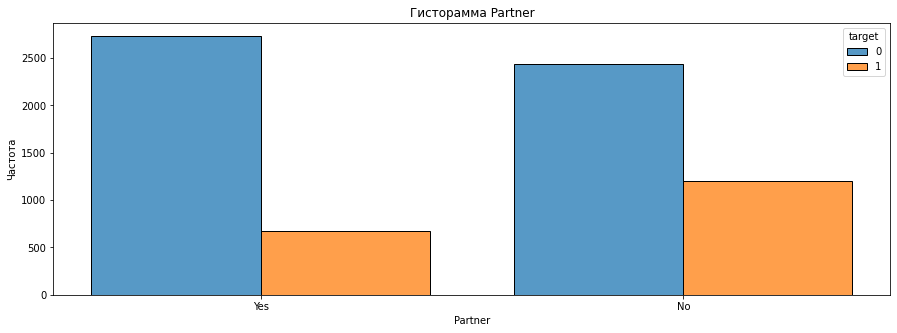

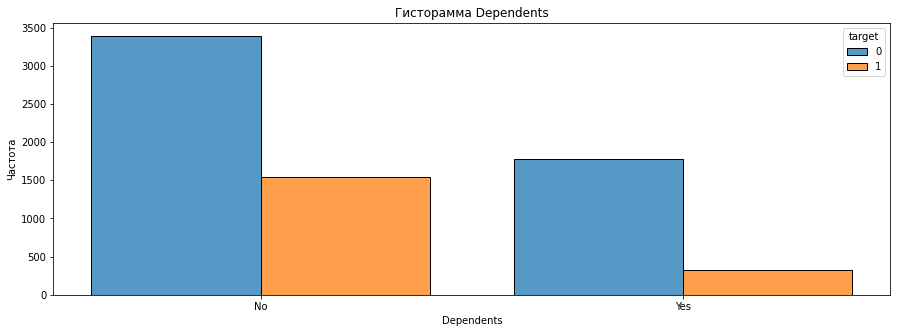

In [2512]:
for i in ['gender','SeniorCitizen','Partner','Dependents']:
    plt.figure(figsize=(15,5))
    sns.histplot(data=contract.merge(personal,how='outer'),x=i,hue='target', multiple="dodge", shrink=.8)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Gender  практически не влияет на таргет.

Закодируем столбцы

In [2513]:
personal = personal.join(pd.get_dummies(personal[['gender','SeniorCitizen','Partner','Dependents']], drop_first=True))
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes
0,7590-VHVEG,Female,0,Yes,No,0,0,1,0
1,5575-GNVDE,Male,0,No,No,1,0,0,0
2,3668-QPYBK,Male,0,No,No,1,0,0,0
3,7795-CFOCW,Male,0,No,No,1,0,0,0
4,9237-HQITU,Female,0,No,No,0,0,0,0


In [2514]:
personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes'],
      dtype='object')

Создадим таблицу, которую будем потом использовать при объедиении данных

In [2515]:
personal_=personal[['customerID',
                    'gender_Male',
                    'SeniorCitizen_1',
                    'Partner_Yes',
                    'Dependents_Yes'
                   ]]

####  Таблица phone

In [2516]:
phone.describe(include='all').T

,count,unique,top,freq
customerID,6361,6361,9861-PDSZP,1
MultipleLines,6361,2,No,3390


In [2517]:
phone = phone.join(pd.get_dummies(phone[['MultipleLines']], drop_first=True))
phone.head(5)

,customerID,MultipleLines,MultipleLines_Yes
0,5575-GNVDE,No,0
1,3668-QPYBK,No,0
2,9237-HQITU,No,0
3,9305-CDSKC,Yes,1
4,1452-KIOVK,Yes,1


Пропусков нет, столбец MultipleLines закодиран

Посмотрим влияние MultipleLines на таргет

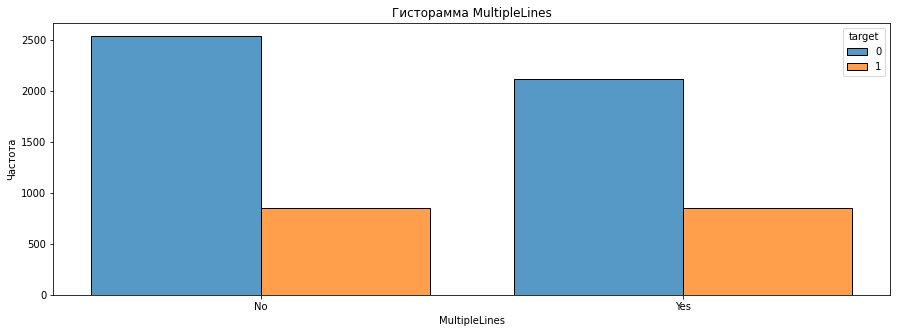

In [2518]:
plt.figure(figsize=(15,5))
sns.histplot(data=contract.merge(phone,how='outer'),x='MultipleLines',hue='target', multiple="dodge", shrink=.8)
plt.ylabel('Частота')
plt.xlabel('MultipleLines')
plt.title(f'Гисторамма MultipleLines')
plt.show()

Столбец практически не влияет на таргет, но пока его оставим для финальной таблицы.
Создадим таблицу для слияния с закодированным показателем MultipleLines

In [2519]:
phone_=phone[['customerID','MultipleLines_Yes']]

### Группировка таблиц и объединение

Посмотрим первые строки объединяемых таблиц

In [2520]:
contract.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,period,period_payment
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,0,1,0,1,0,31.00,1.00
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,"1,889.50",0,1,0,0,0,0,1,"1,036.00",33.18


In [2521]:
internet.head(2)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,0,0,1,0,0,0,0
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,0,1,0,1,0,0,0


In [2522]:
personal.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes
0,7590-VHVEG,Female,0,Yes,No,0,0,1,0
1,5575-GNVDE,Male,0,No,No,1,0,0,0


In [2523]:
phone.head(2)

,customerID,MultipleLines,MultipleLines_Yes
0,5575-GNVDE,No,0
1,3668-QPYBK,No,0


Объединим четыре таблицы по полю customerID

In [2524]:
data_frames = [contract_, internet_, personal_,phone_]
df_ = reduce(lambda  left,right: pd.merge(left,right,on=['customerID'],
                                            how='outer'), data_frames)

In [2525]:
df_.head(5)

,customerID,target,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges,period,period_payment,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes
0,7590-VHVEG,0,0,0,1,0,1,0,29.85,29.85,31.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0,0,1,0,NaN
1,5575-GNVDE,0,1,0,0,0,0,1,56.95,"1,889.50","1,036.00",33.18,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1,0,0,0,0.00
2,3668-QPYBK,1,0,0,1,0,0,1,53.85,108.15,61.00,2.01,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1,0,0,0,0.00
3,7795-CFOCW,0,1,0,0,0,0,0,42.30,"1,840.75","1,371.00",43.52,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1,0,0,0,NaN
4,9237-HQITU,1,0,0,1,0,1,0,70.70,151.65,61.00,2.14,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0.00


Проверим пропуски

In [2526]:
df_.isna().sum()

customerID                                  0
target                                      0
Type_One year                               0
Type_Two year                               0
PaperlessBilling_Yes                        0
PaymentMethod_Credit card (automatic)       0
PaymentMethod_Electronic check              0
PaymentMethod_Mailed check                  0
MonthlyCharges                              0
TotalCharges                                0
period                                      0
period_payment                              0
InternetService_Fiber optic              1526
OnlineSecurity_Yes                       1526
OnlineBackup_Yes                         1526
DeviceProtection_Yes                     1526
TechSupport_Yes                          1526
StreamingTV_Yes                          1526
StreamingMovies_Yes                      1526
gender_Male                                 0
SeniorCitizen_1                             0
Partner_Yes                       

Если информации нет в таблицах, значит данная услуга не предоставлялась клиенту, заполним нулями пропущенные значения

In [2527]:
df_.fillna(0,inplace=True)

In [2528]:
df_.isna().sum()

customerID                               0
target                                   0
Type_One year                            0
Type_Two year                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
MonthlyCharges                           0
TotalCharges                             0
period                                   0
period_payment                           0
InternetService_Fiber optic              0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
DeviceProtection_Yes                     0
TechSupport_Yes                          0
StreamingTV_Yes                          0
StreamingMovies_Yes                      0
gender_Male                              0
SeniorCitizen_1                          0
Partner_Yes                              0
Dependents_Yes                           0
MultipleLin

In [2529]:
df_.columns

Index(['customerID', 'target', 'Type_One year', 'Type_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'MonthlyCharges', 'TotalCharges', 'period', 'period_payment',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'gender_Male', 'SeniorCitizen_1', 'Partner_Yes',
       'Dependents_Yes', 'MultipleLines_Yes'],
      dtype='object')

In [2530]:
f_num =  ['MonthlyCharges','period', 'period_payment','TotalCharges']

In [2531]:
# посмотрим корреляцию факторов
df_.loc[:,f_num].corr().style.applymap(lambda x: f"color: {'red' if (abs(x) > 0.5  and x !=1) else 'black'}")

,MonthlyCharges,period,period_payment,TotalCharges
MonthlyCharges,1.000000,0.247754,0.247539,0.651174
period,0.247754,1.000000,0.998934,0.826109
period_payment,0.247539,0.998934,1.000000,0.826458
TotalCharges,0.651174,0.826109,0.826458,1.000000


Очень высокая корреляция между TotalCharges и всеми другими признаками, поэтому данный столбец не будем включать в итоговый список фичей. Также высокая корреляция между периодом действия договора и периодом проплаченным по договору, оставим для модели только период действия договора

Проверим наличие ложной корреляции, посмотрим скатерплоты

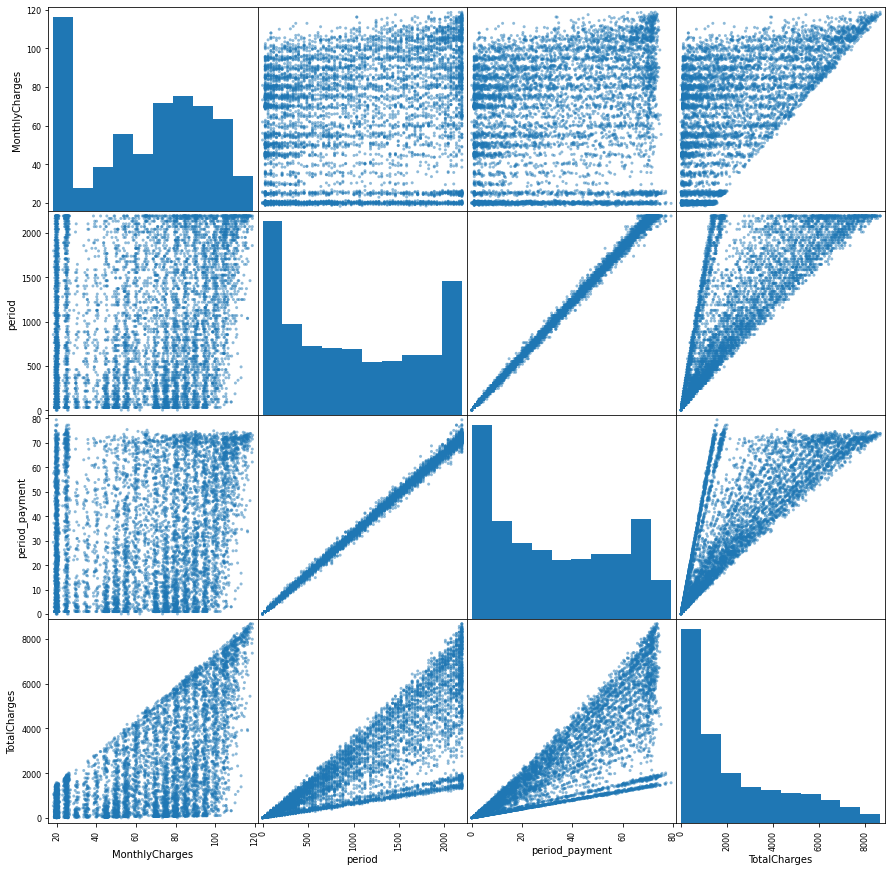

In [2532]:
pd.plotting.scatter_matrix(df_.loc[:,f_num],figsize=(15,15))
plt.show()

**Вывод** для формирования фичей оставим все категориальные признаки и из количественных признаков оставим только период действия договора и ежесячный платеж.

## Построение моделей.

In [2533]:
features = [
    'MonthlyCharges',    
    'Type_One year',
    'Type_Two year',
    'PaperlessBilling_Yes',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check',
    'period',  
    'InternetService_Fiber optic',
    'OnlineSecurity_Yes',
    'OnlineBackup_Yes',
    'DeviceProtection_Yes',
    'TechSupport_Yes',
    'StreamingTV_Yes',
    'StreamingMovies_Yes',
    'gender_Male',
    'SeniorCitizen_1', 
    'Partner_Yes', 
    'Dependents_Yes',
    'MultipleLines_Yes'
]

Выделим тестовую выборку

In [2534]:
X_, X_test, y_, y_test = train_test_split(df_[features],
                                          df_['target'],
                                          test_size=0.2,
                                          random_state=44,
                                          stratify=df_['target'])
X_.shape, y_.shape, X_test.shape, y_test.shape

((5634, 20), (5634,), (1409, 20), (1409,))

Разделим оставшиеся данные на трейновые и валидационную выборки

In [2535]:
X_tr, X_val, y_tr, y_val = train_test_split(X_,
                                            y_,
                                            test_size=0.2,
                                            random_state=44,
                                            stratify = y_)
X_tr.shape, y_tr.shape, X_val.shape, y_test.shape

((4507, 20), (4507,), (1127, 20), (1409,))

### Базовая модель

In [2536]:
log = Pipeline([('sc', StandardScaler()), ('reg', LogisticRegression(random_state=12345))])

In [2537]:
log.fit(X_,y_)

Pipeline(steps=[('sc', StandardScaler()),
                ('reg', LogisticRegression(random_state=12345))])

Создадим Датафрейм с результатами различных моделей

In [2538]:
res=pd.DataFrame(columns=['name_model',
                          'roc_auc',
                          'accuracy',
                          'f1_score',                          
                          'precision',
                          'recall',
                          'num features'                          
                         ],
                 data=[['Базовая модель(logistic regression)',
                        roc_auc_score(y_test,log.predict_proba(X_test)[:, 1]),
                        accuracy_score(y_test,log.predict(X_test)),
                        f1_score(y_test,log.predict(X_test)),
                        precision_score(y_test,log.predict(X_test)),
                        recall_score(y_test,log.predict(X_test)),
                        X_test.shape[1]
                        ]]
                )
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20


### Логистическая регрессия с подбором гиперпараметров на всех признаках

Подберем оптимальные параметры для Логистической регрессии, используя GridSearchCV

In [2539]:
parameters = [{'lreg2__fit_intercept' : [True,False]},
              {'lreg2__fit_intercept' : [True,False],
               'lreg2__penalty' : ['l1'],
               'lreg2__solver' :['saga','liblinear']
              }
             ]
steps = [('standard_scaler', StandardScaler()),
         ('lreg2', LogisticRegression(random_state = 12345))
        ]
pipe = Pipeline(steps)
reg_lreg2 = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
reg_lreg2.fit(X_, y_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('lreg2',
                                        LogisticRegression(random_state=12345))]),
             param_grid=[{'lreg2__fit_intercept': [True, False]},
                         {'lreg2__fit_intercept': [True, False],
                          'lreg2__penalty': ['l1'],
                          'lreg2__solver': ['saga', 'liblinear']}],
             scoring='roc_auc')

In [2540]:
reg_lreg2.best_params_

{'lreg2__fit_intercept': True,
 'lreg2__penalty': 'l1',
 'lreg2__solver': 'liblinear'}

In [2541]:
res.loc[res.shape[0]]=['Logistic Regression c GridSearch все параметры',
                       roc_auc_score(y_test,reg_lreg2.predict_proba(X_test)[:, 1]),
                       accuracy_score(y_test,reg_lreg2.predict(X_test)),
                       f1_score(y_test,reg_lreg2.predict(X_test)),
                       precision_score(y_test,reg_lreg2.predict(X_test)),
                       recall_score(y_test,reg_lreg2.predict(X_test)),
                       X_test.shape[1]
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20


### Случайный лес с подбором гиперпараметров на всех признаках

In [2542]:
# Подберем оптимальные параметры для модели Случайного леса по уменьшенной сбалансированной выборке
parameters = {
    'rf__n_estimators' : [25,50,100,150],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__max_depth':[5,10,20],
}         
steps = [('standard_scaler', StandardScaler()),
         ('rf', RandomForestClassifier(random_state=12345))
        ]
pipe = Pipeline(steps)
cls_rf = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
cls_rf.fit(X_, y_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=12345))]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [5, 10, 20],
                         'rf__n_estimators': [25, 50, 100, 150]},
             scoring='roc_auc')

In [2543]:
cls_rf.best_params_

{'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__n_estimators': 100}

In [2544]:
res.loc[res.shape[0]]=['RandomForest c GridSearch все параметры',
                       roc_auc_score(y_test,cls_rf.predict_proba(X_test)[:, 1]),
                       accuracy_score(y_test,cls_rf.predict(X_test)),
                       f1_score(y_test,cls_rf.predict(X_test)),
                       precision_score(y_test,cls_rf.predict(X_test)),
                       recall_score(y_test,cls_rf.predict(X_test)),
                       X_test.shape[1]
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20
2,RandomForest c GridSearch все параметры,0.87,0.83,0.63,0.75,0.55,20


### Градиентный бустинг с подбором гиперпараметров на всех признаках

для ускорения блокнота здесь уже указаны подобранные гиперпараметры.

In [2545]:
parameters = {
    'gbr__learning_rate' : [0.1,],
    'gbr__n_estimators' : [100,],
    'gbr__max_depth':[3,],
    'gbr__min_samples_split': [2,],
    'gbr__min_samples_leaf': [2,]  
}
steps = [
    ('standard_scaler', StandardScaler()),
    ('gbr', GradientBoostingClassifier(random_state=12345))
]
pipe = Pipeline(steps)

cls_gbr = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cls_gbr.fit(X_, y_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('gbr',
                                        GradientBoostingClassifier(random_state=12345))]),
             param_grid={'gbr__learning_rate': [0.1], 'gbr__max_depth': [3],
                         'gbr__min_samples_leaf': [2],
                         'gbr__min_samples_split': [2],
                         'gbr__n_estimators': [100]},
             scoring='roc_auc')

In [2546]:
cls_gbr.best_params_

{'gbr__learning_rate': 0.1,
 'gbr__max_depth': 3,
 'gbr__min_samples_leaf': 2,
 'gbr__min_samples_split': 2,
 'gbr__n_estimators': 100}

In [2547]:
res.loc[res.shape[0]]=['GradientBoosting c GridSearch все параметры',
                       roc_auc_score(y_test,cls_gbr.predict_proba(X_test)[:, 1]),
                       accuracy_score(y_test,cls_gbr.predict(X_test)),
                       f1_score(y_test,cls_gbr.predict(X_test)),
                       precision_score(y_test,cls_gbr.predict(X_test)),
                       recall_score(y_test,cls_gbr.predict(X_test)),
                       X_test.shape[1]
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20
2,RandomForest c GridSearch все параметры,0.87,0.83,0.63,0.75,0.55,20
3,GradientBoosting c GridSearch все параметры,0.90,0.85,0.68,0.79,0.59,20


###  Оптимизация набора признаков

Оптимизируем набор признаков, используя класс SequentialFeatureSelector модуля sklearn.feature_selection на логистической регрессии.

In [2548]:
model = Pipeline([('sc', StandardScaler()), ('reg', LogisticRegression(random_state=12345))])

Подберем оптимальные параметры, на которых в дальнейшем будем обучать модели.

In [2549]:
best_score = 0
best_num = 0

for num in range(1, X_tr.shape[1]):
    sfs = SequentialFeatureSelector(model, n_features_to_select=num, cv=5,
                          scoring='roc_auc', 
                          direction='forward', n_jobs=-1) 

    sfs.fit(X_tr, y_tr)
    model.fit(X_tr.loc[:, sfs.get_support()], y_tr)
    y_p = model.predict_proba(X_val.loc[:, sfs.get_support()])[:,1]
    score_temp = roc_auc_score(y_val, y_p)
    print(f'Признаков {num}, roc_auc={score_temp}')
    if score_temp>best_score:
      best_score = score_temp
      best_num = num
      best_support = sfs.get_support()

print(f"best roc_auc = {best_score}")
print(f"best num = {best_num}")
best_support

Признаков 1, roc_auc=0.7632224161052139
Признаков 2, roc_auc=0.8280278060523808
Признаков 3, roc_auc=0.8392689803370333
Признаков 4, roc_auc=0.8470828688219992
Признаков 5, roc_auc=0.8479008126928732
Признаков 6, roc_auc=0.8477715573651301
Признаков 7, roc_auc=0.8482279902412228
Признаков 8, roc_auc=0.8492963663095988
Признаков 9, roc_auc=0.8509484109673146
Признаков 10, roc_auc=0.8501849966878322
Признаков 11, roc_auc=0.8512150000807845
Признаков 12, roc_auc=0.8513119415765918
Признаков 13, roc_auc=0.8525580437206147
Признаков 14, roc_auc=0.8521945131113373
Признаков 15, roc_auc=0.8523984941754319
Признаков 16, roc_auc=0.8526872990483577
Признаков 17, roc_auc=0.8526166125409983
Признаков 18, roc_auc=0.8526933578918456
Признаков 19, roc_auc=0.8539253227343964
best roc_auc = 0.8539253227343964
best num = 19


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False])

####  Логистическая регрессия с подбором гиперпараметров на оптимизированных признаках

Обучим логистическую регрессии с базовыми гиперпараметрами на выборке с оптимальными параметрами.

In [2550]:
sfs = SequentialFeatureSelector(model, n_features_to_select=best_num, cv=5,
                          scoring='roc_auc', 
                          direction='forward', n_jobs=-1) 

sfs.fit(X_, y_)

SequentialFeatureSelector(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                    ('reg',
                                                     LogisticRegression(random_state=12345))]),
                          n_features_to_select=19, n_jobs=-1,
                          scoring='roc_auc')

In [2551]:
model.fit(X_.loc[:, sfs.get_support()], y_)

Pipeline(steps=[('sc', StandardScaler()),
                ('reg', LogisticRegression(random_state=12345))])

In [2552]:
res.loc[res.shape[0]]=['LogisticRegression с оптимизацией параметров',
                       roc_auc_score(y_test,model.predict_proba(X_test.loc[:, sfs.get_support()])[:,1]),
                       accuracy_score(y_test,model.predict(X_test.loc[:, sfs.get_support()])),
                       f1_score(y_test,model.predict(X_test.loc[:, sfs.get_support()])),
                       precision_score(y_test,model.predict(X_test.loc[:, sfs.get_support()])),
                       recall_score(y_test,model.predict(X_test.loc[:, sfs.get_support()])),
                       best_num
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20
2,RandomForest c GridSearch все параметры,0.87,0.83,0.63,0.75,0.55,20
3,GradientBoosting c GridSearch все параметры,0.90,0.85,0.68,0.79,0.59,20
4,LogisticRegression с оптимизацией параметров,0.85,0.81,0.59,0.68,0.52,19


In [2553]:
parameters = [{'lreg3__fit_intercept' : [True,False]},  
              {'lreg3__fit_intercept' : [True,False],
               'lreg3__penalty' : ['l1'],
               'lreg3__solver' :['saga','liblinear']
              }
             ]
steps = [('standard_scaler', StandardScaler()),
         ('lreg3', LogisticRegression(random_state = 12345))
        ]
pipe = Pipeline(steps)
reg_lreg3 = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
reg_lreg3.fit(X_.loc[:, sfs.get_support()], y_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('lreg3',
                                        LogisticRegression(random_state=12345))]),
             param_grid=[{'lreg3__fit_intercept': [True, False]},
                         {'lreg3__fit_intercept': [True, False],
                          'lreg3__penalty': ['l1'],
                          'lreg3__solver': ['saga', 'liblinear']}],
             scoring='roc_auc')

In [2554]:
reg_lreg3.best_params_

{'lreg3__fit_intercept': True, 'lreg3__penalty': 'l1', 'lreg3__solver': 'saga'}

In [2555]:
res.loc[res.shape[0]]=['Logistic Regression c GridSearch и оптимальными параметрами',
                       roc_auc_score(y_test,reg_lreg3.predict_proba(X_test.loc[:, sfs.get_support()])[:, 1]),
                        accuracy_score(y_test,reg_lreg3.predict(X_test.loc[:, sfs.get_support()])),
                        f1_score(y_test,reg_lreg3.predict(X_test.loc[:, sfs.get_support()])),
                        precision_score(y_test,reg_lreg3.predict(X_test.loc[:, sfs.get_support()])),
                        recall_score(y_test,reg_lreg3.predict(X_test.loc[:, sfs.get_support()])),
                        best_num
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20
2,RandomForest c GridSearch все параметры,0.87,0.83,0.63,0.75,0.55,20
3,GradientBoosting c GridSearch все параметры,0.90,0.85,0.68,0.79,0.59,20
4,LogisticRegression с оптимизацией параметров,0.85,0.81,0.59,0.68,0.52,19
5,Logistic Regression c GridSearch и оптимальным...,0.85,0.81,0.59,0.68,0.52,19


####  Случайный лес с подбором гиперпараметров на оптимизированных признаках

Обучим случайный лес с подбором гиперпараметров, используя GridSearchCV на выборке с оптимальными параметрами.

In [2556]:
parameters = {
    'rf1__n_estimators' : [25,50,100,150],
    'rf1__criterion' : ['gini', 'entropy'],
    'rf1__max_depth':[5,10,20],
}     
    
steps = [
    ('standard_scaler', StandardScaler()),
    ('rf1', RandomForestClassifier(random_state=12345))
]
pipe = Pipeline(steps)
cls_rf1 = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
cls_rf1.fit(X_.loc[:, sfs.get_support()], y_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('rf1',
                                        RandomForestClassifier(random_state=12345))]),
             param_grid={'rf1__criterion': ['gini', 'entropy'],
                         'rf1__max_depth': [5, 10, 20],
                         'rf1__n_estimators': [25, 50, 100, 150]},
             scoring='roc_auc')

In [2557]:
cls_rf1.best_params_

{'rf1__criterion': 'entropy', 'rf1__max_depth': 10, 'rf1__n_estimators': 150}

In [2558]:
res.loc[res.shape[0]]=['Random Forest c GridSearch и оптимальными параметрами',
                       roc_auc_score(y_test,cls_rf1.predict_proba(X_test.loc[:, sfs.get_support()])[:, 1]),
                       accuracy_score(y_test,cls_rf1.predict(X_test.loc[:, sfs.get_support()])),
                       f1_score(y_test,cls_rf1.predict(X_test.loc[:, sfs.get_support()])),
                       precision_score(y_test,cls_rf1.predict(X_test.loc[:, sfs.get_support()])),
                       recall_score(y_test,cls_rf1.predict(X_test.loc[:, sfs.get_support()])),
                       best_num
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20
2,RandomForest c GridSearch все параметры,0.87,0.83,0.63,0.75,0.55,20
3,GradientBoosting c GridSearch все параметры,0.90,0.85,0.68,0.79,0.59,20
4,LogisticRegression с оптимизацией параметров,0.85,0.81,0.59,0.68,0.52,19
5,Logistic Regression c GridSearch и оптимальным...,0.85,0.81,0.59,0.68,0.52,19
6,Random Forest c GridSearch и оптимальными пара...,0.87,0.83,0.62,0.75,0.53,19


####  Градиентный бустинг с подбором гиперпараметров на оптимизированных признаках

Обучим градиентный бустинг с подбором гиперпараметров, используя GridSearchCV на выборке с оптимальными параметрами.

In [2559]:
parameters = {
    'gbr1__learning_rate' : [0.01,],
    'gbr1__n_estimators' : [250],
    'gbr1__max_depth':[3,],
    'gbr1__min_samples_split': [2,],
    'gbr1__min_samples_leaf': [4]  
}
steps = [
    ('standard_scaler', StandardScaler()),
    ('gbr1', GradientBoostingClassifier(random_state=12345))
]
pipe = Pipeline(steps)

cls_gbr1 = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cls_gbr1.fit(X_.loc[:, sfs.get_support()], y_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('gbr1',
                                        GradientBoostingClassifier(random_state=12345))]),
             param_grid={'gbr1__learning_rate': [0.01], 'gbr1__max_depth': [3],
                         'gbr1__min_samples_leaf': [4],
                         'gbr1__min_samples_split': [2],
                         'gbr1__n_estimators': [250]},
             scoring='roc_auc')

In [2560]:
cls_gbr1.best_params_

{'gbr1__learning_rate': 0.01,
 'gbr1__max_depth': 3,
 'gbr1__min_samples_leaf': 4,
 'gbr1__min_samples_split': 2,
 'gbr1__n_estimators': 250}

In [2561]:
res.loc[res.shape[0]]=['GradientBoosting c GridSearch и оптимальными параметрами',
                       roc_auc_score(y_test,cls_gbr1.predict_proba(X_test.loc[:, sfs.get_support()])[:, 1]),
                       accuracy_score(y_test,cls_gbr1.predict(X_test.loc[:, sfs.get_support()])),
                       f1_score(y_test,cls_gbr1.predict(X_test.loc[:, sfs.get_support()])),
                       precision_score(y_test,cls_gbr1.predict(X_test.loc[:, sfs.get_support()])),
                       recall_score(y_test,cls_gbr1.predict(X_test.loc[:, sfs.get_support()])),
                       best_num
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20
2,RandomForest c GridSearch все параметры,0.87,0.83,0.63,0.75,0.55,20
3,GradientBoosting c GridSearch все параметры,0.90,0.85,0.68,0.79,0.59,20
4,LogisticRegression с оптимизацией параметров,0.85,0.81,0.59,0.68,0.52,19
5,Logistic Regression c GridSearch и оптимальным...,0.85,0.81,0.59,0.68,0.52,19
6,Random Forest c GridSearch и оптимальными пара...,0.87,0.83,0.62,0.75,0.53,19
7,GradientBoosting c GridSearch и оптимальными п...,0.88,0.83,0.59,0.79,0.47,19


## Оценка feature_importances.

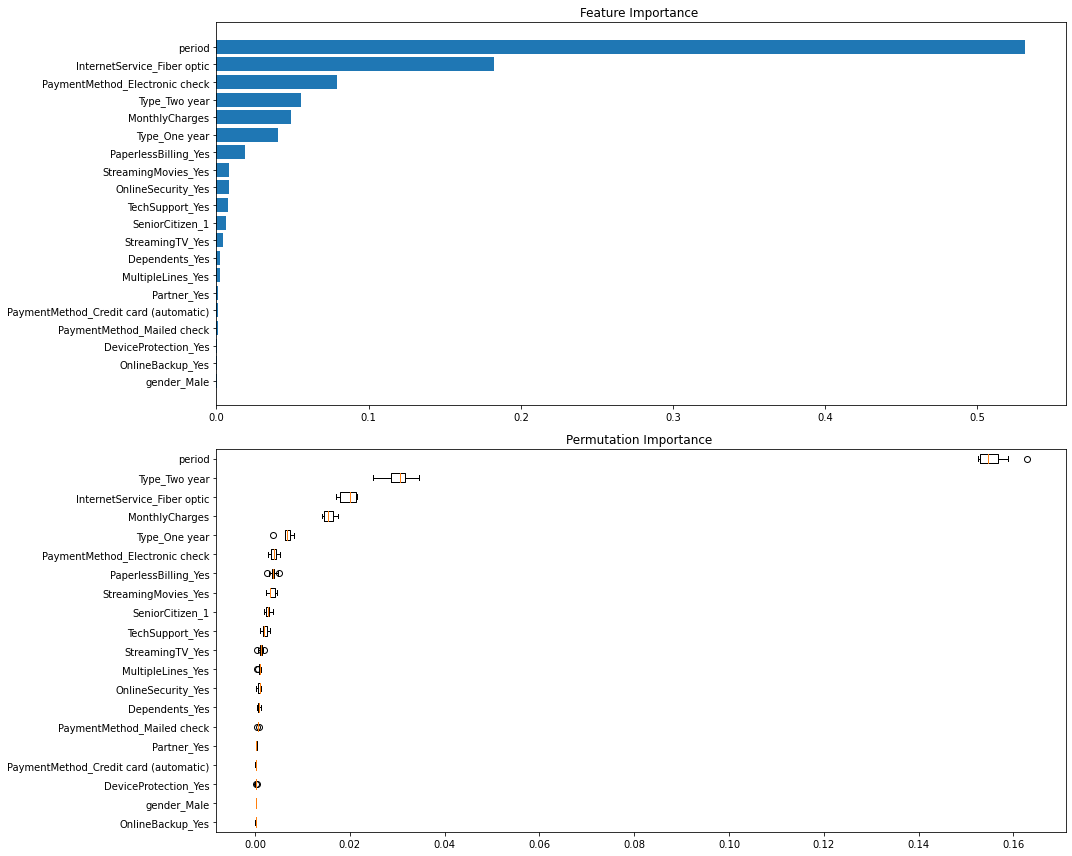

In [2562]:
# Построим график для понимания важности факторов 
feature_importance = cls_gbr.best_estimator_.fit(X_,y_).steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance ")

result = permutation_importance(
    cls_gbr, X_, y_, n_repeats=10, random_state=12345, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(2, 1, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features)[sorted_idx],
)
plt.title("Permutation Importance ")
fig.tight_layout()
plt.show()

Посмотрим параметры , которые были получены при оптимизации, используя SequentialFeatureSelector

In [2563]:
f=np.array(features)
f[best_support]

array(['MonthlyCharges', 'Type_One year', 'Type_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'period', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'gender_Male',
       'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes'], dtype='<U37')

Согласно графику можно выделить 7 ключевых признаков

In [2564]:
f_imp=['period',
       'Type_Two year',
       'InternetService_Fiber optic',
       'PaymentMethod_Electronic check',
       'MonthlyCharges',
       'Type_One year',
       'PaperlessBilling_Yes'
]

In [2565]:
parameters = {
    'gbr2__learning_rate' : [0.01,],
    'gbr2__n_estimators' : [250],
    'gbr2__max_depth':[3,],
    'gbr2__min_samples_split': [2,],
    'gbr2__min_samples_leaf': [4]  
}
steps = [
    ('standard_scaler', StandardScaler()),
    ('gbr2', GradientBoostingClassifier(random_state=12345))
]
pipe = Pipeline(steps)

cls_gbr2 = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cls_gbr2.fit(X_.loc[:, f_imp], y_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('gbr2',
                                        GradientBoostingClassifier(random_state=12345))]),
             param_grid={'gbr2__learning_rate': [0.01], 'gbr2__max_depth': [3],
                         'gbr2__min_samples_leaf': [4],
                         'gbr2__min_samples_split': [2],
                         'gbr2__n_estimators': [250]},
             scoring='roc_auc')

In [2566]:
res.loc[res.shape[0]]=['GradientBoosting c GridSearch и 7 параметрами',
                       roc_auc_score(y_test,cls_gbr2.predict_proba(X_test.loc[:, f_imp])[:, 1]),
                       accuracy_score(y_test,cls_gbr2.predict(X_test.loc[:, f_imp])),
                       f1_score(y_test,cls_gbr2.predict(X_test.loc[:, f_imp])),
                       precision_score(y_test,cls_gbr2.predict(X_test.loc[:, f_imp])),
                       recall_score(y_test,cls_gbr2.predict(X_test.loc[:, f_imp])),
                       7
                      ]
res

,name_model,roc_auc,accuracy,f1_score,precision,recall,num features
0,Базовая модель(logistic regression),0.85,0.81,0.59,0.68,0.53,20
1,Logistic Regression c GridSearch все параметры,0.85,0.81,0.59,0.68,0.53,20
2,RandomForest c GridSearch все параметры,0.87,0.83,0.63,0.75,0.55,20
3,GradientBoosting c GridSearch все параметры,0.90,0.85,0.68,0.79,0.59,20
4,LogisticRegression с оптимизацией параметров,0.85,0.81,0.59,0.68,0.52,19
5,Logistic Regression c GridSearch и оптимальным...,0.85,0.81,0.59,0.68,0.52,19
6,Random Forest c GridSearch и оптимальными пара...,0.87,0.83,0.62,0.75,0.53,19
7,GradientBoosting c GridSearch и оптимальными п...,0.88,0.83,0.59,0.79,0.47,19
8,GradientBoosting c GridSearch и 7 параметрами,0.88,0.83,0.59,0.79,0.48,7


**Вывод**


Для прогнозирования оттока клиентов использовался дополнительный параметр период действия договора ( Дата расторжения договора или дата на которую формируется выгрузка за вычетом Даты подписания договора).  

Целевая переменная определялась по столбцу EndDate.  

В предоставленных данных договора расторгались только начиная с октября 2019, хотя заключались начиная с октября 2013. Необходимо проверить достоверность данных.  

Лучший результат показал градиентный бустинг при использовании полного списка фичей roc auc составил 0,90.
При сокращении параметров модели до 7 самых ключевых :  
- 'period',  
- 'Type_Two year',  
- 'InternetService_Fiber optic',  
- 'PaymentMethod_Electronic check',  
- 'MonthlyCharges',  
- 'Type_One year',  
- 'PaperlessBilling_Yes'.  
качество градиентного бустинга roc_auc немного упало до 0,88. Показатель recall снизился с 0,59 до 0,48.

Оптимизация набора признаков, используя класс SequentialFeatureSelector модуля sklearn.feature_selection на логистической регрессии не показала хороших результатов, был убран только один признак из 20, и качество градиентного бустинга по метрике roc auc составило 0,88. т.е. результат такой же как на 7 ключевых признаках выделенных по графику feature_importances